# Use ClassificationUNN to make LLM

---

# base classes: UNN and ClassificationUNN

In [1]:
import numpy as np
from numpy.typing import NDArray

af64 = NDArray[np.float64]

class UNN:
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        seed: int = 42,
    ):
        np.random.seed(seed)
        self.w1: af64 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1: af64 = np.zeros((1, hidden_size))
        self.w2: af64 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2: af64 = np.zeros((1, output_size))

    def relu(self, x: af64) -> af64:
        return np.maximum(0, x)

    def relu_derivative(self, x: af64) -> af64:
        return (x > 0).astype(float)

    def forward_hidden(self, X: af64):
        self.Z1 = X @ self.w1 + self.b1
        self.A1 = self.relu(self.Z1)

    def backward_hidden(
        self,
        dA1: af64,
        X: af64,
    ) -> tuple[af64, af64, af64]:
        dZ1: af64 = dA1 * self.relu_derivative(self.Z1)
        dW1: af64 = X.T @ dZ1
        db1: af64 = np.sum(dZ1, axis=0, keepdims=True)
        return dZ1 @ self.w1.T, dW1, db1

    def update(
        self,
        grads: tuple[af64, af64, af64, af64],
        lr: float,
    ):
        dW1, db1, dW2, db2 = grads
        self.w1 -= lr * dW1
        self.b1 -= lr * db1
        self.w2 -= lr * dW2
        self.b2 -= lr * db2

class ClassificationUNN(UNN):
    def softmax(self, x: af64) -> af64:
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, X: af64) -> af64:
        self.forward_hidden(X)
        self.Z2 = self.A1 @ self.w2 + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(
        self,
        y_pred: af64,
        y_true: af64,
    ) -> np.float64:
        # y_true is one-hot encoded
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def backward(
        self,
        X: af64,
        y_true: af64,
        y_pred: af64,
    ) -> tuple[af64, af64, af64, af64]:
        dZ2 = (y_pred - y_true) / y_true.shape[0]
        dW2 = self.A1.T @ dZ2
        db2: af64 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.w2.T
        _, dW1, db1 = self.backward_hidden(dA1, X) # _ is dX

        return dW1, db1, dW2, db2

---

# Read dataset

In [2]:
import json

def read_dicts(file: str):
    # Reading from the file
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        encode_dict: dict[str, int] = data['encode_dict']
        decode_dict: dict[str, str] = data['decode_dict']
    return encode_dict, decode_dict

def read_dataset(file: str) -> list[list[int]]:
    with open(file, 'r', encoding='utf-8') as f:
        dataset: list[list[int]] = [list(map(int, line.split())) for line in f]
    return dataset


DICTS_FILE = '05.dicts.json'
encode_dict, decode_dict = read_dicts(DICTS_FILE)
print(encode_dict)
print(decode_dict)

DATASET_PATH = '05.dataset.txt'
dataset = read_dataset(DATASET_PATH)
print(len(dataset))
print(dataset[:5]) # First 5 datapoints
print(dataset[-5:]) # Last 5 datapoints

{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, ':': 25, ';': 26, '<': 27, '=': 28, '>': 29, '?': 30, '@': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, '[': 56, '\\': 57, ']': 58, '^': 59, '_': 60, '`': 61, 'a': 62, 'b': 63, 'c': 64, 'd': 65, 'e': 66, 'f': 67, 'g': 68, 'h': 69, 'i': 70, 'j': 71, 'k': 72, 'l': 73, 'm': 74, 'n': 75, 'o': 76, 'p': 77, 'q': 78, 'r': 79, 's': 80, 't': 81, 'u': 82, 'v': 83, 'w': 84, 'x': 85, 'y': 86, 'z': 87, '{': 88, '|': 89, '}': 90, '~': 91, '上': 92, '分': 93, '区': 94, '大': 95, '海': 96, '赛': 97}
{'0': '\n', '1': ' ', '2': '!', '3': '"', '4': '$', '5': '%', '6': '&', '7': "'", '8': '(', '9': ')', '10': '*', '11': '+', '

---

# Get Mini Batch

In [3]:
import random

def get_mini_batch(
    dataset: list[list[int]],
    n_sample: int,
    n_labels: int,
) -> tuple[
        list[list[int]],
        list[list[int]],
        list[int],
    ]:
    random_sample: list[list[int]] = random.sample(dataset, n_sample)
    x_train: list[list[int]] = [x[:-1] for x in random_sample]
    labels: list[int] = [x[-1] for x in random_sample]
    y_train: list[list[int]] = [
        [1 if i == label else 0 for i in range(n_labels)] for label in labels
    ]
    return x_train, y_train, labels

x_train, y_train, labels = get_mini_batch(dataset, 5, len(encode_dict))
print(x_train)
print(y_train)
print(labels)

print(len(x_train[0]))
print(len(y_train[0]))

[[75, 1, 66, 79, 79, 76, 79, 8, 66, 79, 79, 12, 1, 79, 66, 78, 12, 1, 79, 66, 80, 12, 1, 75, 66, 85, 81, 9, 1], [82, 1, 64, 76, 82, 73, 65, 1, 70, 68, 75, 76, 79, 66, 1, 81, 69, 70, 80, 0, 1, 1, 81, 69, 70, 80, 14, 77, 62], [7, 77, 82, 63, 73, 70, 64, 7, 12, 1, 7, 64, 80, 80, 7, 9, 9, 9, 26, 0, 0, 62, 77, 77, 14, 73, 70, 80, 81], [1, 84, 76, 82, 73, 65, 0, 1, 1, 79, 66, 80, 14, 79, 66, 75, 65, 66, 79, 8, 7, 66, 85, 62, 74, 77, 73, 66, 80], [81, 50, 70, 64, 72, 8, 9, 1, 70, 80, 1, 81, 76, 1, 80, 69, 76, 84, 1, 81, 69, 62, 81, 0, 1, 1, 15, 15, 1]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

---

# encode and decode

In [4]:
def encode(s: str) -> list[int]:
    return [encode_dict[c] for c in s]

def decode(arr: list[int]) -> str:
    return ''.join([decode_dict[str(index)] for index in arr])

print(encode("hello"))
print(decode([69, 66, 73, 73, 76]))

[69, 66, 73, 73, 76]
hello


---

# Preprocessing text

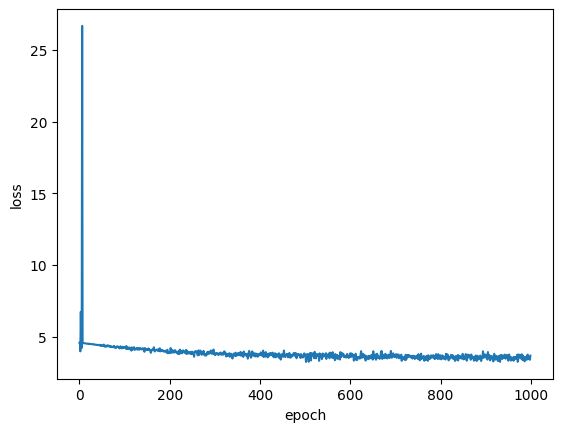

app.post('/login', function (                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [60]:
import matplotlib.pyplot as plt

def test():

    # Initialize model
    model = ClassificationUNN(input_size=29, hidden_size=5, output_size=len(encode_dict))

    # Training loop
    times: int = 1000
    learning_rate: float = 0.1
    losses: list[np.float64] = []

    for _ in range(times):
        X_train, y_train, _ = get_mini_batch(dataset, 64, len(encode_dict))
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Forward pass
        y_pred: af64 = model.forward(X_train)
        
        # Compute loss
        loss = model.compute_loss(y_pred, y_train)
        
        # Backward pass
        grads = model.backward(X_train, y_train, y_pred)
        
        # Update weights
        model.update(grads, lr=learning_rate)
        
        losses.append(loss)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(losses)
    plt.show()

    # Inference
    initial_str: str = "app.post('/login', function ("
    initial_encode: list[int] = encode(initial_str)

    print(initial_str, end="")
    for _ in range(1000):
        output: af64 = model.forward(np.array([initial_encode]))
        next_index: np.intp = np.argmax(output) # 1 for " "
        # next_index = np.argsort(output)[0][-2] # 66 for "e"
        next_char: str = decode_dict[str(next_index)]
        print(next_char, end="")
        initial_encode.pop(0)
        initial_encode.append(int(next_index))

test()

# 

---

# Conclusion
- The model likely predict space " " or "e" because they are most frequently characters
- How to fix it?